### Pacotes:

In [1]:
pip install wfdb

  Using cached wfdb-4.1.2-py3-none-any.whl.metadata (4.3 kB)
  Using cached soundfile-0.12.1-py2.py3-none-manylinux_2_31_x86_64.whl.metadata (14 kB)
Using cached wfdb-4.1.2-py3-none-any.whl (159 kB)
Using cached soundfile-0.12.1-py2.py3-none-manylinux_2_31_x86_64.whl (1.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mapie

  Using cached MAPIE-0.9.1-py3-none-any.whl.metadata (12 kB)
Using cached MAPIE-0.9.1-py3-none-any.whl (178 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install stumpy

  Using cached stumpy-1.13.0-py3-none-any.whl.metadata (28 kB)
Using cached stumpy-1.13.0-py3-none-any.whl (176 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import wfdb
import stumpy
import numpy as np
import pandas as pd
from sklearn import tree
from datetime import datetime
from scipy.stats import randint
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from mapie.subsample import BlockBootstrap
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from mapie.regression import MapieTimeSeriesRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from mapie.metrics import (coverage_width_based, regression_coverage_score, regression_mean_width_score)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.discriminant_analysis import StandardScaler

### **Trabalho 2 - Aprendizado de Máquina para Séries Temporais**

Ada Máris Pereira Mário - Nº USP: 12725432.

Gabriela dos Santos Amaral Nº USP: 13749681.

Jonas Santos Siqueira - Nº USP: 13989752.

#### 1. Load input data and dataset preparation:

In [5]:
energia = pd.read_csv("energydata_complete.csv")
energia['date'] = pd.to_datetime(energia['date'])
energia.set_index('date', inplace=True)
energia = energia.astype(float)

energia.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [6]:
resultados = []
for coluna in energia.columns:
    serie = energia[coluna].dropna()  # Remova valores NaN antes do teste
    result = adfuller(serie)
    estacionaria = result[1] < 0.05  # Verifica se p-valor é menor que 0.05
    resultados.append({
        "Série": coluna,
        "Estatística de Teste": result[0],
        "p-valor": result[1],
        "Estacionária?": "Sim" if estacionaria else "Não"
    })

df_resultados = pd.DataFrame(resultados)
print(df_resultados)

          Série  Estatística de Teste       p-valor Estacionária?
0    Appliances            -21.616378  0.000000e+00           Sim
1        lights            -21.575876  0.000000e+00           Sim
2            T1             -5.737394  6.391284e-07           Sim
3          RH_1             -5.224069  7.849941e-06           Sim
4            T2            -10.877895  1.317352e-19           Sim
5          RH_2            -10.374265  2.222660e-18           Sim
6            T3             -3.575271  6.251770e-03           Sim
7          RH_3             -4.631203  1.131033e-04           Sim
8            T4             -3.644770  4.960607e-03           Sim
9          RH_4             -4.373134  3.310718e-04           Sim
10           T5             -4.744969  6.922161e-05           Sim
11         RH_5            -19.975427  0.000000e+00           Sim
12           T6             -9.581727  2.149510e-16           Sim
13         RH_6             -7.006972  7.080899e-10           Sim
14        

In [7]:
aplicadas = {}
diferenciadas = {}
diferenciacoes_aplicadas = {}
for coluna in energia.columns:
    serie = energia[coluna].dropna()
    estacionaria = False
    diferencas = 0

    while not estacionaria:
        result = adfuller(serie)
        if result[1] < 0.05:
            estacionaria = True
            if diferencas > 0:
                aplicadas[coluna] = diferencas
        else:
            serie = serie.diff().dropna()
            diferencas += 1

    diferenciadas[coluna] = serie
    diferenciacoes_aplicadas[coluna] = diferencas

print("Séries diferenciadas e o número de diferenciações necessárias para torná-las estacionárias:")
for coluna, diferencas in aplicadas.items():
    print(f"A série '{coluna}' tornou-se estacionária após {diferencas} diferenciação(ões).")

df_diferenciadas = pd.DataFrame(diferenciadas)
df_diferenciadas.reset_index(inplace=True)
df_diferenciadas.dropna(inplace=True)

df_diferenciadas.head()

Séries diferenciadas e o número de diferenciações necessárias para torná-las estacionárias:
A série 'T7' tornou-se estacionária após 1 diferenciação(ões).
A série 'T9' tornou-se estacionária após 1 diferenciação(ões).


,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
1,2016-01-11 17:10:00,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,0.033333,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,-0.066667,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,0.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,0.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097
5,2016-01-11 17:50:00,50.0,40.0,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,...,0.000000,45.29,6.016667,734.0,92.0,5.333333,43.833333,4.8,44.919484,44.919484


In [8]:
lags = range(1, 50)
correlacoes = {}
base = df_diferenciadas.copy()

for lag in lags:
    lag_column = f"Lag_{lag}"
    base[lag_column] = base["Appliances"].shift(lag)
    correlacao = base["Appliances"].corr(base[lag_column])
    correlacoes[lag] = correlacao

melhor_lag = max(correlacoes, key=lambda x: abs(correlacoes[x]))

print("Correlação dos lags com a série 'Appliances':")
for lag, corr in correlacoes.items():
    print(f"Lag {lag}: Correlação = {corr:.4f}")

print(f"\nO melhor lag é {melhor_lag}, com correlação = {correlacoes[melhor_lag]:.4f}")

Correlação dos lags com a série 'Appliances':
Lag 1: Correlação = 0.7532
Lag 2: Correlação = 0.5342
Lag 3: Correlação = 0.4378
Lag 4: Correlação = 0.3912
Lag 5: Correlação = 0.3571
Lag 6: Correlação = 0.3237
Lag 7: Correlação = 0.2896
Lag 8: Correlação = 0.2929
Lag 9: Correlação = 0.3226
Lag 10: Correlação = 0.3377
Lag 11: Correlação = 0.3246
Lag 12: Correlação = 0.3111
Lag 13: Correlação = 0.2907
Lag 14: Correlação = 0.2633
Lag 15: Correlação = 0.2375
Lag 16: Correlação = 0.2103
Lag 17: Correlação = 0.1849
Lag 18: Correlação = 0.1706
Lag 19: Correlação = 0.1663
Lag 20: Correlação = 0.1576
Lag 21: Correlação = 0.1446
Lag 22: Correlação = 0.1337
Lag 23: Correlação = 0.1253
Lag 24: Correlação = 0.1141
Lag 25: Correlação = 0.1007
Lag 26: Correlação = 0.0923
Lag 27: Correlação = 0.0876
Lag 28: Correlação = 0.0853
Lag 29: Correlação = 0.0774
Lag 30: Correlação = 0.0697
Lag 31: Correlação = 0.0593
Lag 32: Correlação = 0.0529
Lag 33: Correlação = 0.0486
Lag 34: Correlação = 0.0378
Lag 35: Cor

In [9]:
df_diferenciadas["Weekofyear"] = df_diferenciadas.date.dt.isocalendar().week.astype("int64")
df_diferenciadas["Weekday"] = df_diferenciadas.date.dt.isocalendar().day.astype("int64")
df_diferenciadas["Hour"] = df_diferenciadas.date.dt.hour
df_diferenciadas["Minute"] = df_diferenciadas.date.dt.minute

for minute in range(1, 2):
    df_diferenciadas[f"Lag_{minute}"] = df_diferenciadas["Appliances"].shift(minute)

df_diferenciadas.set_index('date', inplace=True)
df_diferenciadas = df_diferenciadas.astype(float)
df_diferenciadas.dropna(inplace=True)

df_diferenciadas.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,Windspeed,Visibility,Tdewpoint,rv1,rv2,Weekofyear,Weekday,Hour,Minute,Lag_1
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:20:00,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,6.333333,55.333333,5.1,28.642668,28.642668,2.0,1.0,17.0,20.0,60.0
2016-01-11 17:30:00,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,6.000000,51.500000,5.0,45.410389,45.410389,2.0,1.0,17.0,30.0,50.0
2016-01-11 17:40:00,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,5.666667,47.666667,4.9,10.084097,10.084097,2.0,1.0,17.0,40.0,50.0
2016-01-11 17:50:00,50.0,40.0,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,45.730000,...,5.333333,43.833333,4.8,44.919484,44.919484,2.0,1.0,17.0,50.0,60.0
2016-01-11 18:00:00,60.0,50.0,19.89,45.766667,19.2,44.500000,19.79,44.900000,18.890000,45.790000,...,5.000000,40.000000,4.7,47.233763,47.233763,2.0,1.0,18.0,0.0,50.0


In [10]:
steps_per_hour = 6
hours_per_day = 24
days_per_week = 7

num_test_steps = steps_per_hour * hours_per_day * days_per_week  # 1008 passos

# Aplicar o brutal changepoint nos últimos passos do conjunto de teste
changepoint_start = -num_test_steps
df_diferenciadas.loc[df_diferenciadas.index[changepoint_start:], 'Appliances'] -= 2  # Reduzindo em 2 kW

print("Brutal changepoint aplicado nos últimos 7 dias de dados!")
df_diferenciadas.tail(10)

Brutal changepoint aplicado nos últimos 7 dias de dados!


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,Windspeed,Visibility,Tdewpoint,rv1,rv2,Weekofyear,Weekday,Hour,Minute,Lag_1
date,,,,,,,,,,,,,,,,,,,,,
2016-05-27 16:30:00,218.0,0.0,25.426667,46.060000,26.000000,41.700000,28.000000,40.760000,24.7,45.400000,...,2.500000,22.500000,13.300000,23.009520,23.009520,21.0,5.0,16.0,30.0,100.0
2016-05-27 16:40:00,178.0,0.0,25.500000,46.530000,26.000000,41.725714,27.856667,40.500000,24.7,45.500000,...,2.666667,22.333333,13.333333,25.296732,25.296732,21.0,5.0,16.0,40.0,220.0
2016-05-27 16:50:00,118.0,0.0,25.500000,47.456667,26.000000,42.320000,27.663333,40.693333,24.7,45.560000,...,2.833333,22.166667,13.366667,1.796395,1.796395,21.0,5.0,16.0,50.0,180.0
2016-05-27 17:00:00,108.0,0.0,25.600000,47.193333,25.968571,42.528571,27.390000,41.030000,24.7,45.626667,...,3.000000,22.000000,13.400000,18.248201,18.248201,21.0,5.0,17.0,0.0,120.0
2016-05-27 17:10:00,88.0,0.0,25.533333,46.860000,25.978000,42.534000,27.323333,41.090000,24.7,45.626667,...,3.166667,22.833333,13.366667,16.966162,16.966162,21.0,5.0,17.0,10.0,110.0
2016-05-27 17:20:00,98.0,0.0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,...,3.333333,23.666667,13.333333,43.096812,43.096812,21.0,5.0,17.0,20.0,90.0
2016-05-27 17:30:00,88.0,0.0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,...,3.500000,24.500000,13.300000,49.282940,49.282940,21.0,5.0,17.0,30.0,100.0
2016-05-27 17:40:00,268.0,10.0,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,...,3.666667,25.333333,13.266667,29.199117,29.199117,21.0,5.0,17.0,40.0,90.0
2016-05-27 17:50:00,418.0,10.0,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,...,3.833333,26.166667,13.233333,6.322784,6.322784,21.0,5.0,17.0,50.0,270.0


#### 2. Optimize the base estimator:

In [11]:
appliances_train = df_diferenciadas.iloc[:-num_test_steps, :].copy()
appliances_test = df_diferenciadas.iloc[-num_test_steps:, :].copy()
features = ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
            'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
            'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
            'Tdewpoint', 'rv1', 'rv2', 'Weekofyear', 'Weekday', 'Hour', 'Minute']
features += [f"Lag_{hour}" for hour in range(1, 2)]

X_train = appliances_train.loc[
    ~np.any(appliances_train[features].isnull(), axis=1), features
]

y_train = appliances_train.loc[X_train.index, "Appliances"]
X_test = appliances_test.loc[:, features]
y_test = appliances_test["Appliances"]

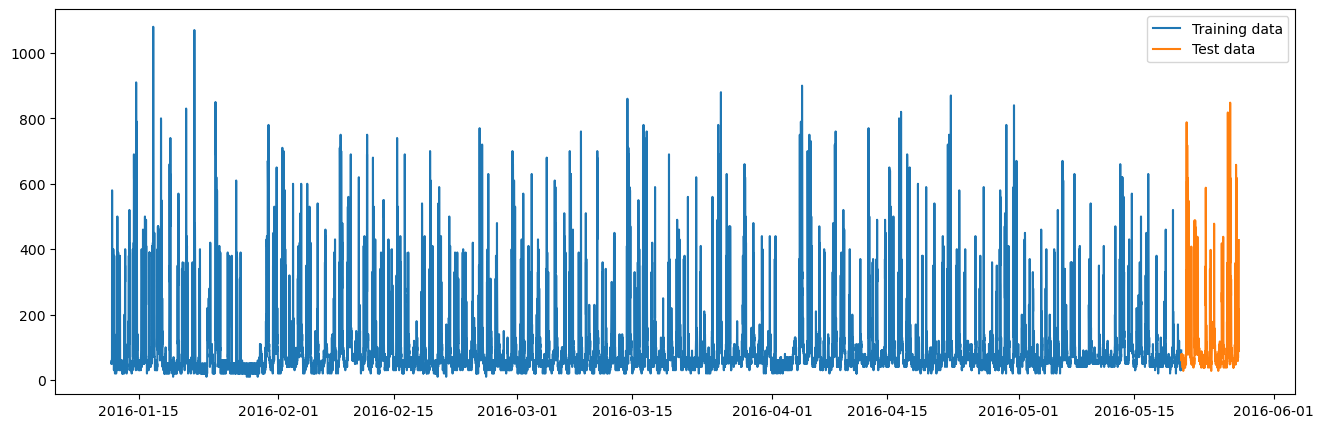

In [12]:
plt.figure(figsize=(16, 5))
plt.plot(y_train)
plt.plot(y_test)
plt.legend(["Training data", "Test data"])
plt.show()

In [17]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
model_params_fit_not_done = False
if model_params_fit_not_done:
    # CV parameter search
    n_iter = 100
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    random_state = 59
    rf_model = RandomForestRegressor(random_state=random_state)
    rf_params = {"max_depth": randint(2, 30), "n_estimators": randint(10, 100)}
    cv_obj = RandomizedSearchCV(
        rf_model,
        param_distributions=rf_params,
        n_iter=n_iter,
        cv=tscv,
        scoring="neg_root_mean_squared_error",
        random_state=random_state,
        verbose=0,
        n_jobs=-1,
    )
    cv_obj.fit(X_train, y_train)
    model = cv_obj.best_estimator_
else:
    # Model: Random Forest previously optimized with a cross-validation
    model = RandomForestRegressor(
        max_depth=10, n_estimators=50, random_state=59
    )

In [19]:
# Função para cálculo do MAPE:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Cálculo das métricas:
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Métricas no Conjunto de Treino:")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"MAPE: {train_mape:.2f}%")
print(f"R²: {train_r2:.4f}")
# ======================================= #
print("\nMétricas no Conjunto de Teste:")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"MAPE: {test_mape:.2f}%")
print(f"R²: {test_r2:.4f}")

Métricas no Conjunto de Treino:
RMSE: 49.6553
MAE: 23.6418
MAPE: 23.96%
R²: 0.7622

Métricas no Conjunto de Teste:
RMSE: 77.6960
MAE: 38.1798
MAPE: 30.72%
R²: 0.5300


#### 3. Estimate prediction intervals on the test set:

In [78]:
alpha = 0.05
gap = 8
cv_mapiets = BlockBootstrap(
    n_resamplings=100, n_blocks=125, overlapping=True, random_state=59
)
mapie_enbpi = MapieTimeSeriesRegressor(
    model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1
)

In [ ]:
# For EnbPI
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

y_pred_enbpi_npfit, y_pis_enbpi_npfit = mapie_enbpi.predict(
    X_test, alpha=alpha, ensemble=True, optimize_beta=True,
    allow_infinite_bounds=True
)
y_pis_enbpi_npfit = np.nan_to_num(y_pis_enbpi_npfit)
coverage_enbpi_npfit = regression_coverage_score(
    y_test, y_pis_enbpi_npfit[:, 0, 0], y_pis_enbpi_npfit[:, 1, 0]
)
width_enbpi_npfit = regression_mean_width_score(
    y_pis_enbpi_npfit[:, 0, 0], y_pis_enbpi_npfit[:, 1, 0]
)
cwc_enbpi_npfit = coverage_width_based(
    y_test, y_pis_enbpi_npfit[:, 0, 0],
    y_pis_enbpi_npfit[:, 1, 0],
    eta=10,
    alpha=0.05
)

In [115]:
mapie_enbpi = MapieTimeSeriesRegressor(
    model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1
)
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

y_pred_enbpi_pfit = np.zeros(y_pred_enbpi_npfit.shape)
y_pis_enbpi_pfit = np.zeros(y_pis_enbpi_npfit.shape)

# Previsão inicial
y_pred_enbpi_pfit[:gap], y_pis_enbpi_pfit[:gap, :, :] = mapie_enbpi.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=True,
    allow_infinite_bounds=True
)
# Ordenação explícita dos limites
y_pis_enbpi_pfit[:gap, :, :] = np.sort(y_pis_enbpi_pfit[:gap, :, :], axis=1)

# Loop para previsão iterativa
for step in range(gap, len(X_test), gap):
    # Atualização do modelo com partial_fit
    mapie_enbpi.partial_fit(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )
    y_pred_enbpi_pfit[step:step + gap], y_pis_enbpi_pfit[step:step + gap, :, :] = mapie_enbpi.predict(
        X_test.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True,
        allow_infinite_bounds=True
    )
    # Ajuste dos limites e ordenação explícita
    y_pis_enbpi_pfit[step:step + gap, :, :] = np.sort(y_pis_enbpi_pfit[step:step + gap, :, :], axis=1)

# Métricas
coverage_enbpi_pfit = regression_coverage_score(
    y_test, y_pis_enbpi_pfit[:, 0, 0], y_pis_enbpi_pfit[:, 1, 0]
)
width_enbpi_pfit = regression_mean_width_score(
    y_pis_enbpi_pfit[:, 0, 0], y_pis_enbpi_pfit[:, 1, 0]
)
cwc_enbpi_pfit = coverage_width_based(
    y_test, y_pis_enbpi_pfit[:, 0, 0], y_pis_enbpi_pfit[:, 1, 0],
    eta=10,
    alpha=0.05
)

/opt/conda/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


#### 4. Plot estimated prediction intervals on one-step ahead forecast:

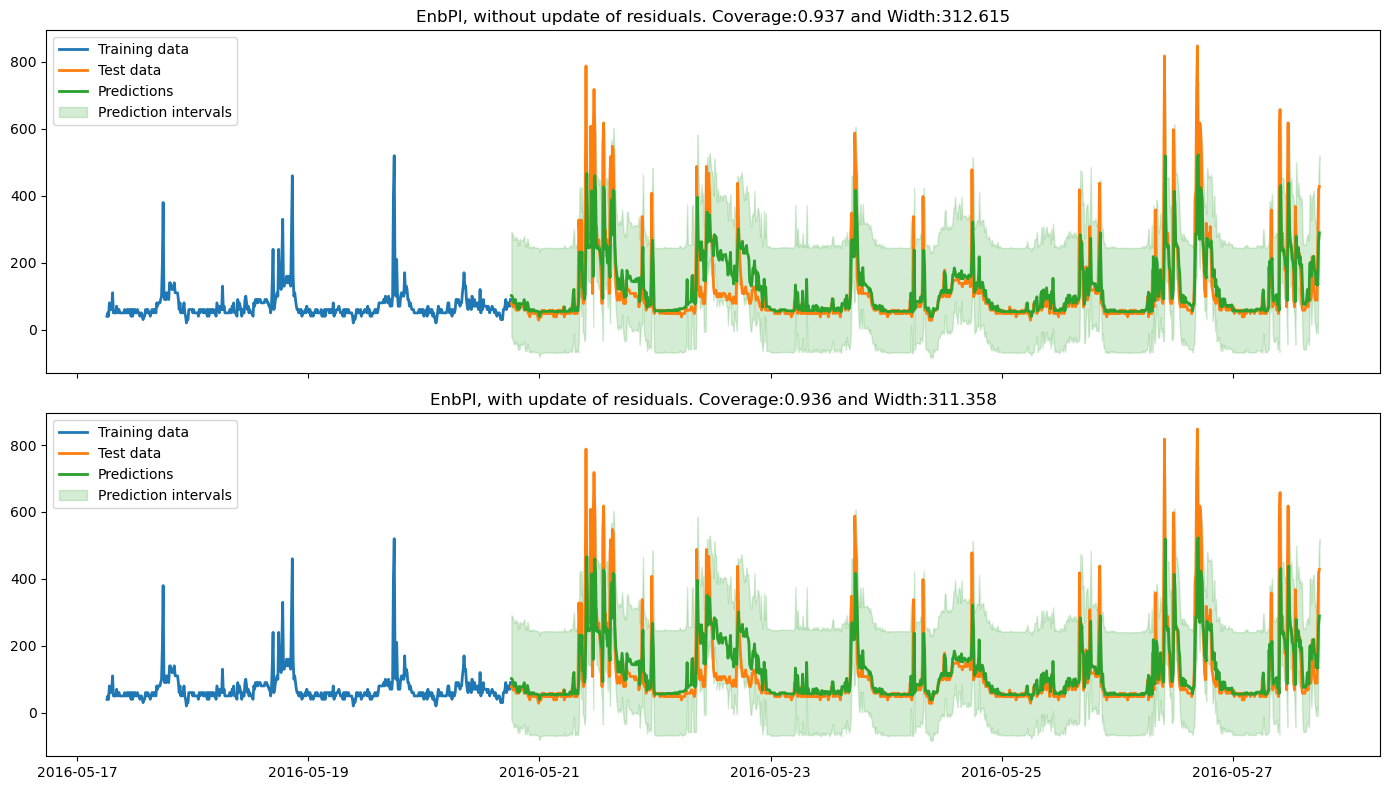

In [131]:
y_enbpi_preds = [y_pred_enbpi_npfit, y_pred_enbpi_pfit]
y_enbpi_pis = [y_pis_enbpi_npfit, y_pis_enbpi_pfit]
coverages_enbpi = [coverage_enbpi_npfit, coverage_enbpi_pfit]
widths_enbpi = [width_enbpi_npfit, width_enbpi_pfit]

fig, axs = plt.subplots(
    nrows=2, ncols=1, figsize=(14, 8), sharey="row", sharex="col"
)
for i, (ax, w) in enumerate(zip(axs, ["without", "with"])):
    ax.plot(
        y_train[int(-len(y_test)/2):],
        lw=2,
        label="Training data", c="C0"
    )
    ax.plot(y_test, lw=2, label="Test data", c="C1")

    ax.plot(
        y_test.index, y_enbpi_preds[i], lw=2, c="C2", label="Predictions"
    )
    ax.fill_between(
        y_test.index,
        y_enbpi_pis[i][:, 0, 0],
        y_enbpi_pis[i][:, 1, 0],
        color="C2",
        alpha=0.2,
        label="Prediction intervals",
    )
    title = f"EnbPI, {w} update of residuals. "
    title += (f"Coverage:{coverages_enbpi[i]:.3f} and "
                f"Width:{widths_enbpi[i]:.3f}")
    ax.set_title(title)
    ax.legend()
fig.tight_layout()
plt.show()